In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import riskfolio as rp
from scipy.linalg import sqrtm

pd.options.display.float_format = '{:.4%}'.format

In [22]:
def marginal_risk_contrib (p, cov_m):
    '''
    p: vector de pesos
    cov_m: matriz de covarianzas
    '''
    sigma_p = np.sqrt(p @ cov_m @ p)
    return cov_m @ p / sigma_p

In [23]:
def risk_contrib(p, cov_m):
    '''
    p: vector de pesos
    cov_m: matriz de covarianzas
    '''
    mrc = marginal_risk_contrib(p, cov_m)
    return p * mrc

In [4]:
start = '2000-01-01'
end = '2022-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']

prices.columns = assets

returns = prices.pct_change().dropna()

[*********************100%%**********************]  25 of 25 completed


<Axes: xlabel='Date'>

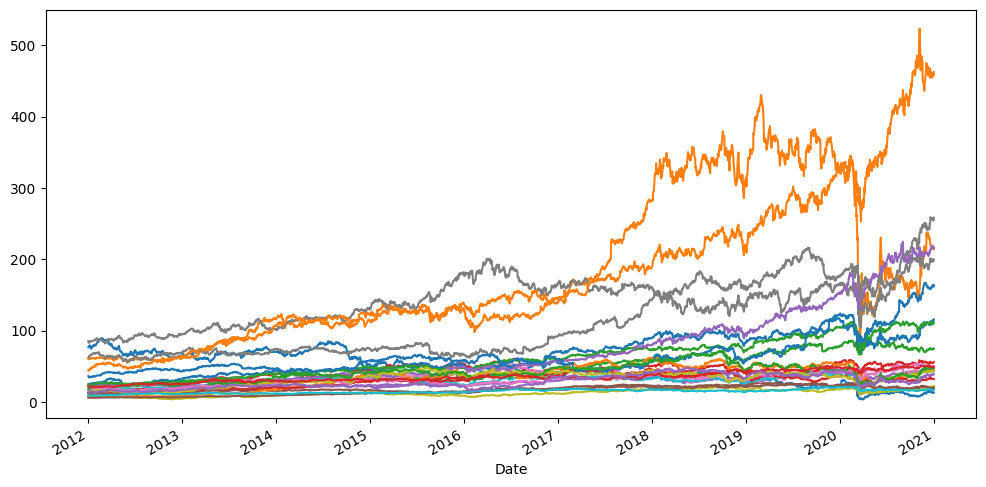

In [16]:
prices.loc['2012':'2020'].plot(figsize=(12,6), legend=False)

In [49]:

returns_2007 = returns.loc[:'2007']
returns_2012 = returns.loc['2008':'2012']
retornos_2020 = returns.loc['2012':'2020']


Cartera Risk Parity

In [20]:
T, n = returns_2007.shape

Sigma = returns_2007.cov().to_numpy()
mu = returns_2007.mean().to_numpy().reshape(-1,1)

# Equal Risk Contribution
b = 1/n

In [21]:
x = cp.Variable((n,1))
gamma = cp.Variable((n,1), nonneg=True)
psi = cp.Variable(nonneg=True)

z = Sigma @ x

obj = cp.pnorm(b**0.5 * psi - gamma, p=2)
ret = mu.T @ x

constraints = [cp.sum(x) == 1,
               x >= 0,
               cp.SOC(psi, sqrtm(Sigma) @ x),
               # ret >= 0.0006,
               ]

for i in range(n):
    constraints += [cp.SOC(x[i,0] + z[i,0],
                           cp.vstack([2*gamma[i:i+1], x[i:i+1] - z[i:i+1]]))
                    ]

objective = cp.Minimize(obj * 1000)
prob = cp.Problem(objective, constraints)
prob.solve(solver='MOSEK')

pesos_rp = pd.DataFrame(x.value, index=assets)


Cartera Mínima Volatilidad

In [25]:
# Cartera de mínima volatilidad

pesos_min = cp.Variable((n,1))

constraints = [pesos_min >= 0,
                cp.sum(pesos_min) == 1]

riesgo_min = cp.quad_form(pesos_min, Sigma) # Riesgo de la cartera
objective = cp.Minimize(riesgo_min) # Minimizar la varianza

prob = cp.Problem(objective, constraints)
resultado = prob.solve()

pesos_min_df = pd.DataFrame(pesos_min.value, index=assets)

In [33]:
pesos_eq = pd.DataFrame(np.ones(n)/n, index=assets)

In [38]:
(returns_2012 @ pesos_eq).cumsum()

,0
Date,
2008-01-02,-1.4775%
2008-01-03,-1.4569%
2008-01-04,-3.8541%
2008-01-07,-3.3300%
2008-01-08,-5.5538%
...,...
2012-12-24,48.3754%
2012-12-26,47.8569%
2012-12-27,47.6675%


In [43]:
retornos_2012_eq = (returns_2012 @ pesos_eq)
retornos_2012_rp = (returns_2012 @ pesos_rp)
retornos_2012_min = (returns_2012 @ pesos_min_df)


In [68]:
retornos_2012_eq.std(), retornos_2012_rp.std(), retornos_2012_min.std()

(0   1.7108%
 dtype: float64,
 0   1.6634%
 dtype: float64,
 0   1.6514%
 dtype: float64)

In [47]:
precios_2012_eq = retornos_2012_eq.cumsum()
precios_2012_rp = retornos_2012_rp.cumsum()
precios_2012_min = retornos_2012_min.cumsum()

<Axes: title={'center': 'Precios de los Activos'}, xlabel='Date'>

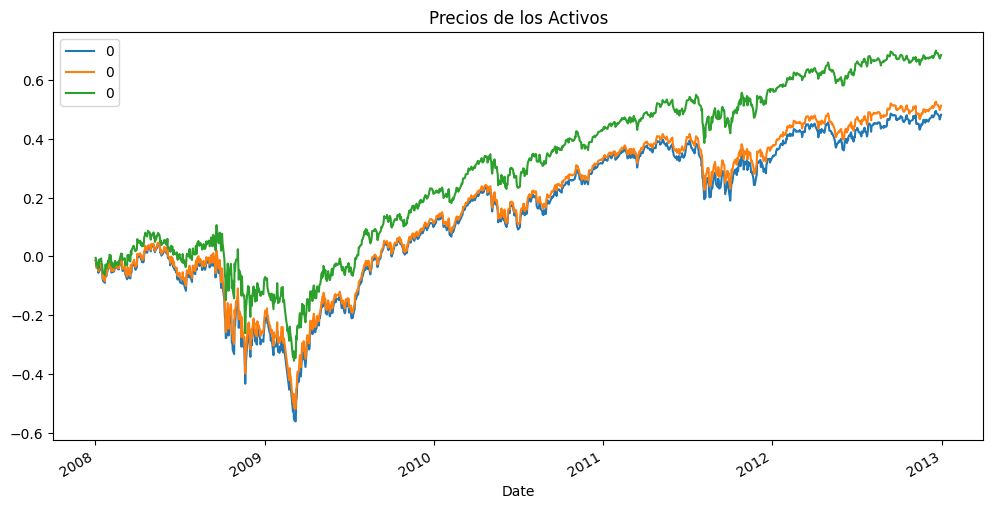

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))

# Dibujar cada serie en el mismo eje
precios_2012_eq.plot(ax=ax, legend=True, title='Precios de los Activos')
precios_2012_rp.plot(ax=ax, legend=True)
precios_2012_min.plot(ax=ax, legend=True)


In [60]:
retornos_2020_eq = (retornos_2020 @ pesos_eq)
retornos_2020_rp = (retornos_2020 @ pesos_rp)
retornos_2020_min = (retornos_2020 @ pesos_min_df)

In [77]:
retornos_2020_eq[0].std()

0.010604198543266656

In [80]:
# Desviación estándar 2020
std_eq_2012 = np.sqrt(252) * retornos_2012_eq[0].std()
std_rp_2012 = np.sqrt(252) * retornos_2012_rp[0].std()
std_min_2012 = np.sqrt(252) * retornos_2012_min[0].std()

# Media 2020
mean_eq_2012 = 252 * retornos_2012_eq[0].mean()
mean_rp_2012 = 252 * retornos_2012_rp[0].mean()
mean_min_2012 = 252 * retornos_2012_min[0].mean()

# Imprimir los valores con formato para 2012
print("Desviación Estándar 2012:\nEQ: {:.4f}, RP: {:.4f}, MIN: {:.4f}".format(std_eq_2012, std_rp_2012, std_min_2012))
print("Media 2012:\nEQ: {:.4f}, RP: {:.4f}, MIN: {:.4f}".format(mean_eq_2012, mean_rp_2012, mean_min_2012))


Desviación Estándar 2012:
EQ: 0.2716, RP: 0.2641, MIN: 0.2621
Media 2012:
EQ: 0.0965, RP: 0.1027, MIN: 0.1371


In [81]:
# Desviación estándar 2020
std_eq_2020 = np.sqrt(252) * retornos_2020_eq[0].std()
std_rp_2020 = np.sqrt(252) * retornos_2020_rp[0].std()
std_min_2020 = np.sqrt(252) * retornos_2020_min[0].std()

# Media 2020
mean_eq_2020 = 252 * retornos_2020_eq[0].mean()
mean_rp_2020 = 252 * retornos_2020_rp[0].mean()
mean_min_2020 = 252 * retornos_2020_min[0].mean()

# Imprimir los valores con formato para 2020
print("Desviación Estándar 2020:\nEQ: {:.4f}, RP: {:.4f}, MIN: {:.4f}".format(std_eq_2020, std_rp_2020, std_min_2020))
print("Media 2020:\nEQ: {:.4f}, RP: {:.4f}, MIN: {:.4f}".format(mean_eq_2020, mean_rp_2020, mean_min_2020))



Desviación Estándar 2020:
EQ: 0.1683, RP: 0.1640, MIN: 0.1547
Media 2020:
EQ: 0.1615, RP: 0.1532, MIN: 0.1296


In [64]:
precios_2020_eq = retornos_2020_eq.cumsum()
precios_2020_rp = retornos_2020_rp.cumsum()
precios_2020_min = retornos_2020_min.cumsum()

<Axes: title={'center': 'Precios de los Activos'}, xlabel='Date'>

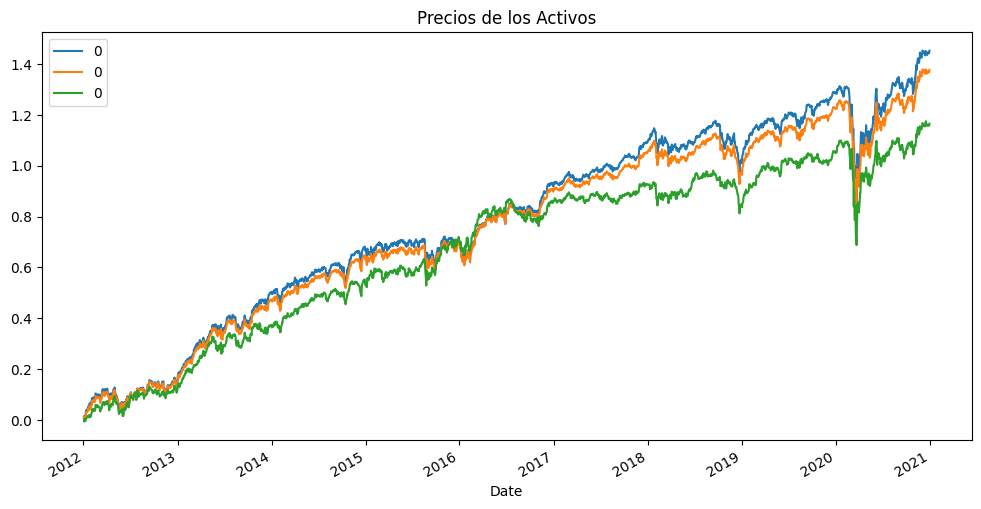

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

# Dibujar cada serie en el mismo eje
precios_2020_eq.plot(ax=ax, legend=True, title='Precios de los Activos')
precios_2020_rp.plot(ax=ax, legend=True)
precios_2020_min.plot(ax=ax, legend=True)